This repository accompanies the MSc dissertation. It contains notebooks and scripts to:
- construct labels for **bad-pass** turnovers from NBA play-by-play (PBP) data,
- build a **two-stage stacked model** (Stage-1 LightGBM prior + Stage-2 Random Forest),
- evaluate **in-season** performance (2023) and **cross-season** generalisation (2021–2023),
- generate plots, reliability curves, and a small **interactive module** for slicing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             brier_score_loss, precision_score,
                             recall_score, f1_score)
np.random.seed(42)


In [2]:
data_path = Path("nbastats_2023.csv")
df_raw = pd.read_csv(data_path)
print("Total number of events:", len(df_raw))
df_raw.head()


Total number of events: 567665


,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,22300001,2,12,0,1,7:11 PM,12:00,NaN,Start of 1st Period (7:11 PM EST),NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0
1,22300001,4,10,0,1,7:11 PM,12:00,Jump Ball Turner vs. Allen: Tip to Toppin,NaN,NaN,...,Cavaliers,CLE,4,1630167,Obi Toppin,1.610613e+09,Indiana,Pacers,IND,1
2,22300001,7,1,108,1,7:12 PM,11:41,Turner 2' Cutting Dunk Shot (2 PTS) (Haliburto...,NaN,NaN,...,Pacers,IND,0,0,NaN,NaN,NaN,NaN,NaN,1
3,22300001,9,2,47,1,7:12 PM,11:23,NaN,NaN,MISS Mobley 8' Turnaround Jump Shot,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1
4,22300001,10,4,0,1,7:12 PM,11:20,Turner REBOUND (Off:0 Def:1),NaN,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1


- construct labels for **bad-pass** turnovers from NBA play-by-play (PBP) data,

In [3]:
TURNOVER = 5       # EVENTMSGTYPE
BADPASS  = 1       # EVENTMSGACTIONTYPE

df = df_raw[df_raw.EVENTMSGTYPE == TURNOVER].copy()
df["target"] = (df.EVENTMSGACTIONTYPE == BADPASS).astype(int)
print("Proportion of incorrect passes:", round(df.target.mean(), 4))


Proportion of incorrect passes: 0.3494


Feature Engineering

In [4]:
# Feature Engineering
def score2num(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().replace("'", "")
    return 0.0 if x.upper()=="TIE" else pd.to_numeric(x, errors="coerce")

def clock2sec(t):
    if pd.isna(t): return np.nan
    try: m,s = map(int, str(t).strip().split(":")); return m*60+s
    except: return np.nan

df["score_margin"]    = df.SCOREMARGIN.apply(score2num)
df["sec_left_period"] = df.PCTIMESTRING.apply(clock2sec)
df["sec_left_game"]   = df.sec_left_period + np.where(df.PERIOD<=4,
                                                      (4-df.PERIOD)*720, 0)

for k in (1,2,3):
    df[f"prev_ev{k}"] = (df.groupby("GAME_ID")["EVENTMSGTYPE"]
                           .shift(k).fillna(0).astype(int))

df["score_bin"] = pd.cut(df.score_margin,
                         [-40,-15,-5,5,15,40],
                         labels=["<-15","-15~-5","-5~5","5~15",">15"])
df["time_bin"]  = pd.cut(df.sec_left_period,
                         [0,60,180,360,720],
                         labels=["0-1min","1-3","3-6","6-12"])

df = df.sort_values(["GAME_ID","PERIOD","sec_left_period"],
                    ascending=[True,True,False])
df["bp_last20events"] = (df.groupby("GAME_ID")["target"]
                      .rolling(20,1).sum()
                      .reset_index(level=0, drop=True))

num_cols = ["PERIOD","sec_left_period","sec_left_game","bp_last20events",
            "score_margin",
            "prev_ev1","prev_ev2","prev_ev3"]
cat_cols = ["PLAYER1_TEAM_ID","score_bin","time_bin"]

X = df[num_cols + cat_cols].copy()
y = df["target"]; groups = df["GAME_ID"]

for c in cat_cols:
    X[c] = X[c].astype("category")

print("Feature matrix:", X.shape, " Proportional example:", y.mean().round(3))


Feature matrix: (33467, 11)  Proportional example: 0.349


Train LGBM under **GroupKFold(game)**; store out-of-fold predictions as prior scores.

In [5]:
# Nested version 5-fold OOF probability
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMClassifier
import numpy as np

def generate_oof_pred_nested(
    X, y, groups, cat_cols, base_params,
    outer_splits=3, inner_splits=5, seed=42 #The first-level prediction for each sample is generated by the "model that has not seen this sample".ction for each sample is generated by the "model that has not seen this sample".
                          #At the same time, the fold_id (outer layer fold number) is returned to facilitate the evaluation of the second-level model on the same outer layer partition (with no leakage) in the subsequent stage.
):
    y = np.asarray(y)
    oof_full = np.empty(len(y), dtype=float); oof_full[:] = np.nan
    fold_id  = np.empty(len(y), dtype=int);   fold_id[:]  = -1

    gkf_outer = GroupKFold(n_splits=outer_splits)
    for i, (tr, te) in enumerate(gkf_outer.split(X, y, groups), 1):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr       = y[tr]
        groups_tr  = groups.iloc[tr]

        # Only perform "inner 5-fold" on the outer training set
        oof_tr = np.zeros(len(tr), dtype=float)
        gkf_inner = GroupKFold(n_splits=inner_splits)
        for tr2, te2 in gkf_inner.split(X_tr, y_tr, groups_tr):
            clf = LGBMClassifier(**base_params, random_state=seed)
            clf.fit(X_tr.iloc[tr2], y_tr[tr2], categorical_feature=cat_cols)
            oof_tr[te2] = clf.predict_proba(X_tr.iloc[te2])[:, 1]

        # Train the primary model at the "full-scale retraining" level in the outer training set, which is used to predict the outer test set.
        clf = LGBMClassifier(**base_params, random_state=seed)
        clf.fit(X_tr, y_tr, categorical_feature=cat_cols)
        pred_te = clf.predict_proba(X_te)[:, 1]

        # Only the first-level predictions from the outer test set are written back to the full oof; the oof_tr from the training set is only used to train the secondary model within the outer loop.
        oof_full[te] = pred_te
        fold_id[te]  = i

    assert not np.isnan(oof_full).any(), "Some samples did not receive the prediction from the outer test."
    return oof_full, fold_id

# Configuration and invocation
best_params = dict(
    n_estimators=600, learning_rate=0.05,
    num_leaves=63, min_child_samples=20,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, class_weight="balanced"
)

# Generate the first-level predictive feature of "no leakage"
oof_pred, outer_fold_id = generate_oof_pred_nested(
    X, y, groups, cat_cols, best_params,
    outer_splits=3, inner_splits=5, seed=42
)

print(f"[Nested] Outer-OOF AUC = {roc_auc_score(y, oof_pred):.4f}")




[LightGBM] [Info] Number of positive: 6179, number of negative: 11670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 17849, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 6230, number of negative: 11618
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 17848, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM]

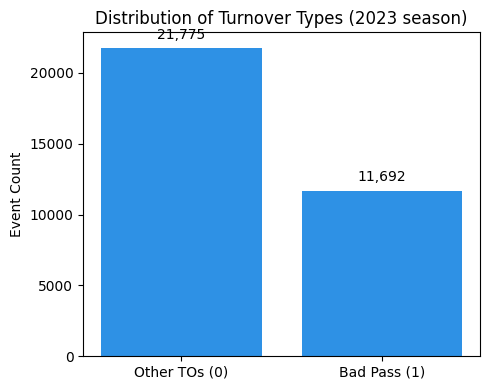

In [6]:
# Visualization: Distribution of "Bad-Pass" vs. Other Errors
counts = df["target"].value_counts().sort_index()
labels  = ["Other TOs (0)", "Bad Pass (1)"]

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(labels, counts.values, color="#2E91E5")
ax.set_title("Distribution of Turnover Types (2023 season)")
ax.set_ylabel("Event Count")

# Write the quantity at the top of the column.
for bar, v in zip(bars, counts.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        v + counts.max() * 0.02,
        f"{v:,}",           
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()



- build a **two-stage stacked model** (Stage-1 LightGBM prior + Stage-2 Random Forest),

In [7]:
# Multi-model evaluation (3-fold Group CV)
from sklearn.compose      import ColumnTransformer
from sklearn.pipeline     import Pipeline
from sklearn.impute       import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble     import RandomForestClassifier
from sklearn.dummy        import DummyClassifier
from lightgbm             import LGBMClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics      import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.linear_model import LogisticRegression
import joblib, time, warnings, pandas as pd
warnings.filterwarnings("ignore")

# transformers 
num_imp     = SimpleImputer(strategy="median")
num_imp_sc  = Pipeline([("imp", num_imp), ("sc", StandardScaler())])

cat_oh      = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh",  OneHotEncoder(handle_unknown="ignore"))
])
cat_ord     = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

prep_tree = ColumnTransformer([
    ("num", num_imp, num_cols),
    ("cat", cat_oh,  cat_cols)
])
prep_lgb  = ColumnTransformer([
    ("num", num_imp, num_cols),
    ("cat", cat_ord, cat_cols)
])

# model dict 
models = {
    "RandomForest": Pipeline([
        ("prep", prep_tree),
        ("clf", RandomForestClassifier(
            n_estimators=400,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        ))
    ]),

    "LightGBM": Pipeline([
        ("prep", prep_lgb),
        ("clf", LGBMClassifier(
            n_estimators=800,
            num_leaves=127,
            learning_rate=0.05,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        ))
    ]),

    "LogisticRegression": Pipeline([
        ("prep", ColumnTransformer([
            ("num", num_imp_sc, num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
        ])),
        ("clf", LogisticRegression(
            solver="liblinear",       
            class_weight="balanced",
            max_iter=1000,
            random_state=42
        ))
    ]),

    "Dummy": Pipeline([
        ("prep", prep_tree),
        ("clf", DummyClassifier(
            strategy="stratified",
            random_state=42
        ))
    ])
}

#3-fold Group CV 
outer = GroupKFold(n_splits=3)
summary, t0 = {}, time.perf_counter()

for name, pipe in models.items():
    oof = np.zeros(len(y))
    metrics = []

    for f, (tr, te) in enumerate(outer.split(X, y, groups), 1):
        Xt, Xv, yt, yv = X.iloc[tr], X.iloc[te], y.iloc[tr], y.iloc[te]

        est = pipe.fit(Xt, yt)
        joblib.dump(est, f"best_{name}_f{f}.joblib")

        p = est.predict_proba(Xv)[:, 1]
        oof[te] = p
        metrics.append([
            roc_auc_score(yv, p),
            average_precision_score(yv, p),
            brier_score_loss(yv, p)
        ])

    np.save(f"oof_{name}.npy", oof)
    summary[name] = np.mean(metrics, axis=0)


print("\n=== 3-fold mean ===")
print(pd.DataFrame(summary, index=["AUC", "AP", "Brier"]).T.round(4))
print(round((time.perf_counter() - t0) / 60, 1), "min")


[LightGBM] [Info] Number of positive: 7767, number of negative: 14544
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 22311, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 7786, number of negative: 14525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 22311, number of used features: 9
[LightGBM] [Info] [binary:

In [8]:

from sklearn.compose      import ColumnTransformer
from sklearn.pipeline     import Pipeline
from sklearn.impute       import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble     import RandomForestClassifier
from sklearn.dummy        import DummyClassifier
from lightgbm             import LGBMClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics      import roc_auc_score, average_precision_score, brier_score_loss
import joblib, time, warnings, pandas as pd

warnings.filterwarnings("ignore")

#  transformers 
num_imp     = SimpleImputer(strategy="median")
num_imp_sc  = Pipeline([("imp", num_imp), ("sc", StandardScaler())])

cat_oh      = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh",  OneHotEncoder(handle_unknown="ignore"))
])
cat_ord     = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

prep_tree = ColumnTransformer([
    ("num", num_imp, num_cols),
    ("cat", cat_oh,  cat_cols)
])
prep_lgb  = ColumnTransformer([
    ("num", num_imp, num_cols),
    ("cat", cat_ord, cat_cols)
])

#  model dict 
models = {
    "RandomForest": Pipeline([
        ("prep", prep_tree),
        ("clf", RandomForestClassifier(
            n_estimators=400,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        ))
    ]),

    "LightGBM": Pipeline([
        ("prep", prep_lgb),
        ("clf", LGBMClassifier(
            n_estimators=800,
            num_leaves=127,
            learning_rate=0.05,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        ))
    ]),
    "Dummy": Pipeline([
        ("prep", prep_tree),
        ("clf", DummyClassifier(
            strategy="stratified",
            random_state=42
        ))
    ])
}

# 3-fold Group CV 
outer = GroupKFold(n_splits=3)
summary, t0 = {}, time.perf_counter()

for name, pipe in models.items():
    oof = np.zeros(len(y))
    metrics = []

    for f, (tr, te) in enumerate(outer.split(X, y, groups), 1):
        Xt, Xv, yt, yv = X.iloc[tr], X.iloc[te], y.iloc[tr], y.iloc[te]

        est = pipe.fit(Xt, yt)
        joblib.dump(est, f"best_{name}_f{f}.joblib")

        p = est.predict_proba(Xv)[:, 1]
        oof[te] = p
        metrics.append([
            roc_auc_score(yv, p),
            average_precision_score(yv, p),
            brier_score_loss(yv, p)
        ])

    np.save(f"oof_{name}.npy", oof)
    summary[name] = np.mean(metrics, axis=0)


print("\n=== 3-fold mean ===")
print(pd.DataFrame(summary, index=["AUC", "AP", "Brier"]).T.round(4))
print( round((time.perf_counter() - t0) / 60, 1), "min")



[LightGBM] [Info] Number of positive: 7767, number of negative: 14544
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 22311, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 7786, number of negative: 14525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 22311, number of used features: 9
[LightGBM] [Info] [binary:

In [9]:
# Add oof_pred to the feature matrix to create a two-layer model
X_stk = X.copy()
X_stk["oof_pred"] = oof_pred          # From Cell 4
num_cols_stk = num_cols + ["oof_pred"]

# update ColumnTransformers: Just put oof_pred into the numerical column
prep_tree_stk = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols_stk),
    ("cat", cat_oh,  cat_cols)
])
prep_lgb_stk  = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols_stk),
    ("cat", cat_ord, cat_cols)
])

models_stk = {
    "Stacked_RF": Pipeline([
        ("prep", prep_tree_stk),
        ("clf", RandomForestClassifier(
            n_estimators=300, class_weight="balanced",max_depth=20,
            min_samples_split=10,
            min_samples_leaf=4,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1, random_state=42))
    ]),
    "Stacked_LGBM": Pipeline([
        ("prep", prep_lgb_stk),
        ("clf", LGBMClassifier(
            n_estimators=600, num_leaves=63, learning_rate=0.05,
            class_weight="balanced", n_jobs=-1, random_state=42))
    ])
}

outer = GroupKFold(n_splits=3)
summary, t0 = {}, time.perf_counter()

for name, pipe in models_stk.items():
    oof = np.zeros(len(y)); metrics=[]
    for f,(tr,te) in enumerate(outer.split(X_stk, y, groups), 1):
        Xt,Xv,yt,yv = X_stk.iloc[tr], X_stk.iloc[te], y.iloc[tr], y.iloc[te]
        est = pipe.fit(Xt, yt)
        p   = est.predict_proba(Xv)[:,1];  oof[te] = p
        metrics.append([
            roc_auc_score(yv,p),
            average_precision_score(yv,p),
            brier_score_loss(yv,p)
        ])
    summary[name] = np.mean(metrics, axis=0)

print("\n=== 3-fold mean (stacking) ===")
print(pd.DataFrame(summary, index=["AUC","AP","Brier"]).T.round(4))
print( round((time.perf_counter()-t0)/60,1), "min")


[LightGBM] [Info] Number of positive: 7767, number of negative: 14544
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 22311, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 7786, number of negative: 14525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 22311, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM

evaluate **in-season** performance (2023) and **cross-season** generalisation (2021–2023),
generate plots, reliability curves, and a small **interactive module** for slicing.

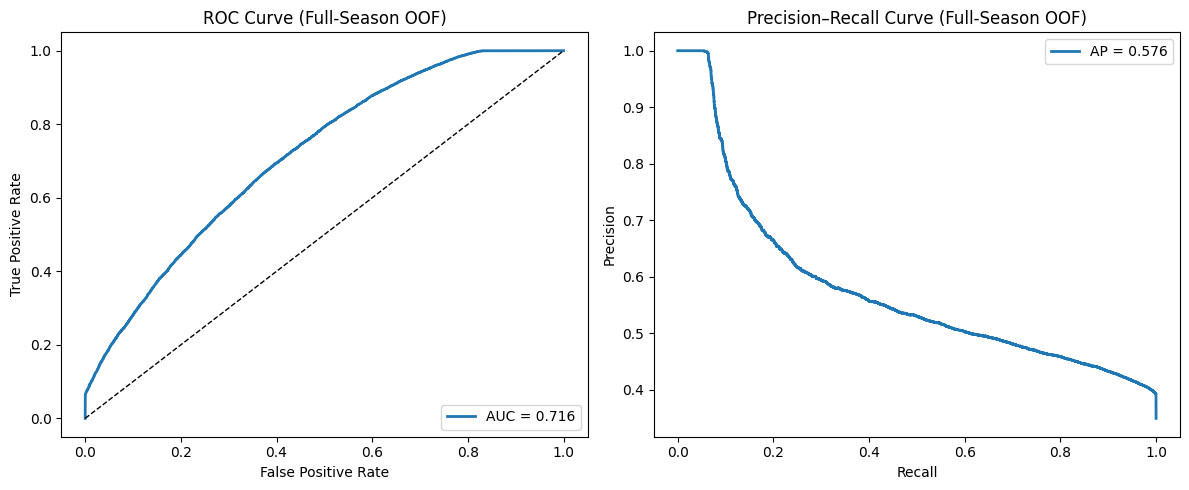

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)


from sklearn.pipeline     import Pipeline
from sklearn.compose      import ColumnTransformer
from sklearn.impute       import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble     import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics      import roc_auc_score, average_precision_score, brier_score_loss


X_stk = X.copy()
X_stk["oof_pred"] = oof_pred
num_cols_stk = num_cols + ["oof_pred"]

prep_tree_stk = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols_stk),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh",  OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

pipe = Pipeline([
    ("prep", prep_tree_stk),
    ("clf", RandomForestClassifier(
       n_estimators=300, class_weight="balanced",max_depth=20,
            min_samples_split=10,
            min_samples_leaf=4,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1, random_state=42
    ))
])

# Generate OOF prediction
oof = np.zeros(len(y))
gkf = GroupKFold(n_splits=3)
for tr, te in gkf.split(X_stk, y, groups):
    est = pipe.fit(X_stk.iloc[tr], y.iloc[tr])
    oof[te] = est.predict_proba(X_stk.iloc[te])[:, 1]

# ─
y_true = y  # Full set of true labels
y_score = oof

fpr, tpr, _ = roc_curve(y_true, y_score)
auc_score   = roc_auc_score(y_true, y_score)

prec, rec, _ = precision_recall_curve(y_true, y_score)
ap_score     = average_precision_score(y_true, y_score)

plt.figure(figsize=(12,5))

# ROC
plt.subplot(1,2,1)
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Full-Season OOF)")
plt.legend(loc="lower right")

# Precision–Recall
plt.subplot(1,2,2)
plt.plot(rec, prec, lw=2, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Full-Season OOF)")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


frozen-model

In [11]:
import joblib

# Stacked_RF serves as the final model
final_model = models_stk["Stacked_RF"].fit(X_stk, y)
joblib.dump(final_model, "stacked_rf_2023_final.joblib")
print("Saved final model to stacked_rf_2023_final.joblib")


Saved final model to stacked_rf_2023_final.joblib


In [12]:
# Ensure that the competition-level hold-out variable exists
from sklearn.model_selection import train_test_split
games = df["GAME_ID"].unique()           # All competition IDs
train_games, test_games = train_test_split(
    games, test_size=0.2, random_state=42
)


5 Flod GroupKFold CV Verification

In [13]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import numpy as np, time

# Match-level hold-out division
mask_tr = df.GAME_ID.isin(train_games)
mask_te = df.GAME_ID.isin(test_games)
Xt, yt = X_stk[mask_tr], y[mask_tr]
Xh, yh = X_stk[mask_te], y[mask_te]

#  5 Flod GroupKFold CV 
outer = GroupKFold(n_splits=3)
print("=== 3-fold GroupCV ===")
for name in ["Stacked_RF", "Stacked_LGBM"]:
    aucs, aps = [], []
    for tr, te in outer.split(X_stk, y, groups):
        est = models_stk[name].fit(X_stk.iloc[tr], y.iloc[tr])
        p   = est.predict_proba(X_stk.iloc[te])[:,1]
        aucs.append(roc_auc_score(y.iloc[te], p))
        aps.append(average_precision_score(y.iloc[te], p))
    print(f"{name:<13} AUC {np.mean(aucs):.4f}  AP {np.mean(aps):.4f}")

# hold-out 
print("\n Hold-out 20 % CompetitionCompetition ")
for name in ["Stacked_RF", "Stacked_LGBM"]:
    est   = models_stk[name].fit(Xt, yt)
    proba = est.predict_proba(Xh)[:,1]
    print(f"{name:<13}  AUC {roc_auc_score(yh, proba):.4f}  "
          f"AP {average_precision_score(yh, proba):.4f}  "
          f"F1 {f1_score(yh, proba>0.5):.4f}")


=== 3-fold GroupCV ===
Stacked_RF    AUC 0.7160  AP 0.5762
[LightGBM] [Info] Number of positive: 7767, number of negative: 14544
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 22311, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 7786, number of negative: 14525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 

In [14]:
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import GroupKFold
import numpy as np

y_rand = shuffle(y, random_state=42).reset_index(drop=True)
cv = GroupKFold(n_splits=3)

print("=== Random-label sanity check ===")
for name in ["Stacked_RF", "Stacked_LGBM"]:
    aucs, aps = [], []
    for tr, te in cv.split(X_stk, y_rand, groups):
        est = models_stk[name].fit(X_stk.iloc[tr], y_rand.iloc[tr])
        p   = est.predict_proba(X_stk.iloc[te])[:,1]
        aucs.append(roc_auc_score(y_rand.iloc[te], p))
        aps.append(average_precision_score(y_rand.iloc[te], p))
    print(f"{name:<13}  AUC {np.mean(aucs):.3f}  AP {np.mean(aps):.3f}")
# The expected value should be approximately 0.50 / 0.35. If it is significantly higher, there is still a risk of leakage.


=== Random-label sanity check ===
Stacked_RF     AUC 0.493  AP 0.346
[LightGBM] [Info] Number of positive: 7751, number of negative: 14560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 22311, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 7830, number of negative: 14481
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the t

[LightGBM] [Info] Number of positive: 9373, number of negative: 17380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 26753, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


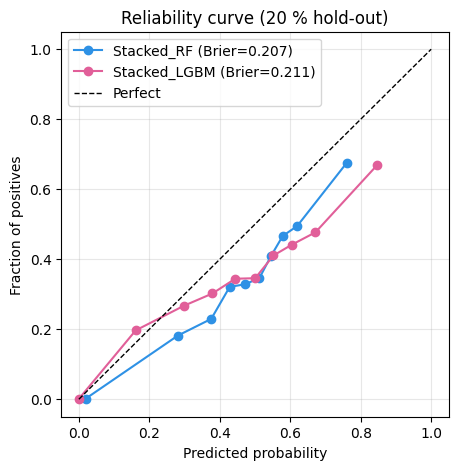

In [15]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
for name, color in zip(["Stacked_RF", "Stacked_LGBM"], ["#2E91E5", "#E15F99"]):
    est   = models_stk[name].fit(Xt, yt)       # Do heavy training in 80% of the competitions
    proba = est.predict_proba(Xh)[:,1]         # 在 Evaluate on the 20% hold-out set
    brier = brier_score_loss(yh, proba)
    pt, pp = calibration_curve(yh, proba, n_bins=10, strategy="quantile")
    plt.plot(pp, pt, marker='o', color=color, label=f"{name} (Brier={brier:.3f})")

plt.plot([0,1], [0,1], 'k--', lw=1, label="Perfect")
plt.xlabel("Predicted probability"); plt.ylabel("Fraction of positives")
plt.title("Reliability curve (20 % hold-out)")
plt.grid(alpha=.3); plt.legend(); plt.show()


feature importance

[LightGBM] [Info] Number of positive: 11692, number of negative: 21775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 33467, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


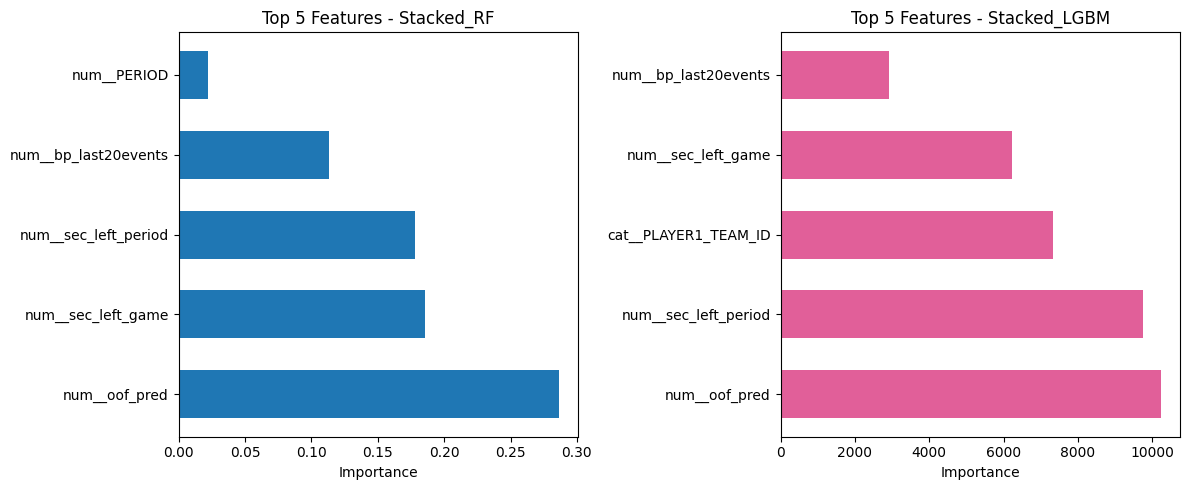

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
 
if 'rf_full' not in globals():
    rf_full = models_stk["Stacked_RF"].fit(X_stk, y)
if 'lgb_full' not in globals():
    lgb_full = models_stk["Stacked_LGBM"].fit(X_stk, y)

#Extract feature names  importance 
feat_names_rf  = rf_full.named_steps['prep'].get_feature_names_out()
imps_rf        = rf_full.named_steps['clf'].feature_importances_

feat_names_lgb = lgb_full.named_steps['prep'].get_feature_names_out()
imps_lgb       = lgb_full.named_steps['clf'].feature_importances_

# Select Top-5
topk    = 5
rf_idx  = np.argsort(imps_rf)[::-1][:topk]
lgb_idx = np.argsort(imps_lgb)[::-1][:topk]

# Draw side-by-side comparison charts 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].barh(feat_names_rf[rf_idx][::-1], imps_rf[rf_idx][::-1], height=0.6)
axes[0].set_title("Top 5 Features - Stacked_RF")
axes[0].invert_yaxis()
axes[0].set_xlabel("Importance")

axes[1].barh(feat_names_lgb[lgb_idx][::-1], imps_lgb[lgb_idx][::-1],
             height=0.6, color="#E15F99")
axes[1].set_title("Top 5 Features - Stacked_LGBM")
axes[1].invert_yaxis()
axes[1].set_xlabel("Importance")

plt.tight_layout()
plt.close(fig)
display(Image("Feature importance.png"))


In [17]:

X_stk = X.copy()
X_stk["oof_pred"] = oof_pred



In [18]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc",  StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh",  OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

# Random Forest Pipeline
pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        class_weight="balanced"
    ))
])

# Search space (excluding n_estimators as it is a resource)
param_dist = {
    "clf__max_depth":         [None, 10, 20],
    "clf__min_samples_split": [2, 10],
    "clf__min_samples_leaf":  [1, 4],
    "clf__max_features":      ["sqrt", "log2"],
    "clf__bootstrap":         [True, False],
}

# 4) Set up GroupKFold and HalvingRandomSearchCV
gkf = GroupKFold(n_splits=2)
halving_search = HalvingRandomSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    factor=3,
    resource="clf__n_estimators",
    min_resources=100,
    max_resources=800,
    scoring="roc_auc",
    cv=gkf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


halving_search.fit(X, y, groups=groups)


print("Best AUC   :", halving_search.best_score_)
print("Best params:", halving_search.best_params_)


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 100
max_resources_: 800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 100
Fitting 2 folds for each of 8 candidates, totalling 16 fits
----------
iter: 1
n_candidates: 3
n_resources: 300
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best AUC   : 0.7038002299072398
Best params: {'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_features': 'sqrt', 'clf__max_depth': 20, 'clf__bootstrap': True, 'clf__n_estimators': 300}


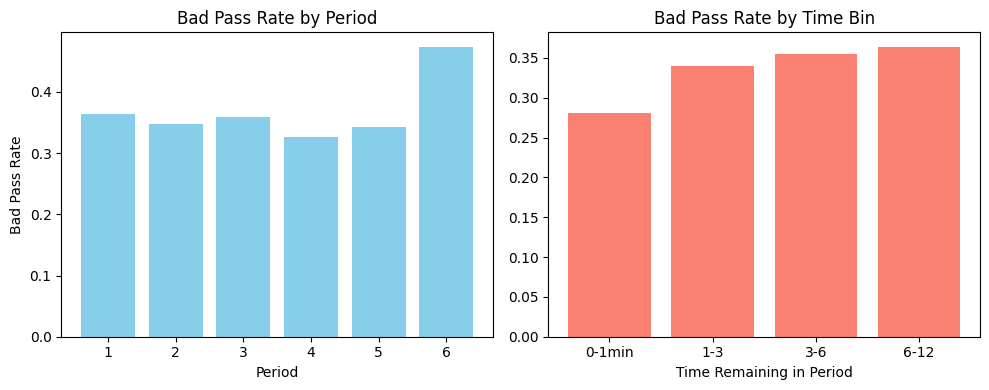

In [19]:
# Section-wise Bad-Pass Rate
period_rate = df.groupby("PERIOD")["target"].mean()
# Classify by remaining time into "Bad-Pass" rate
time_rate   = df.groupby("time_bin")["target"].mean().reindex(["0-1min","1-3","3-6","6-12"])

fig,axs = plt.subplots(1,2,figsize=(10,4))
axs[0].bar(period_rate.index.astype(str), period_rate.values, color="skyblue")
axs[0].set_xlabel("Period"); axs[0].set_ylabel("Bad Pass Rate")
axs[0].set_title("Bad Pass Rate by Period")

axs[1].bar(time_rate.index, time_rate.values, color="salmon")
axs[1].set_xlabel("Time Remaining in Period"); axs[1].set_title("Bad Pass Rate by Time Bin")
plt.tight_layout(); plt.show()


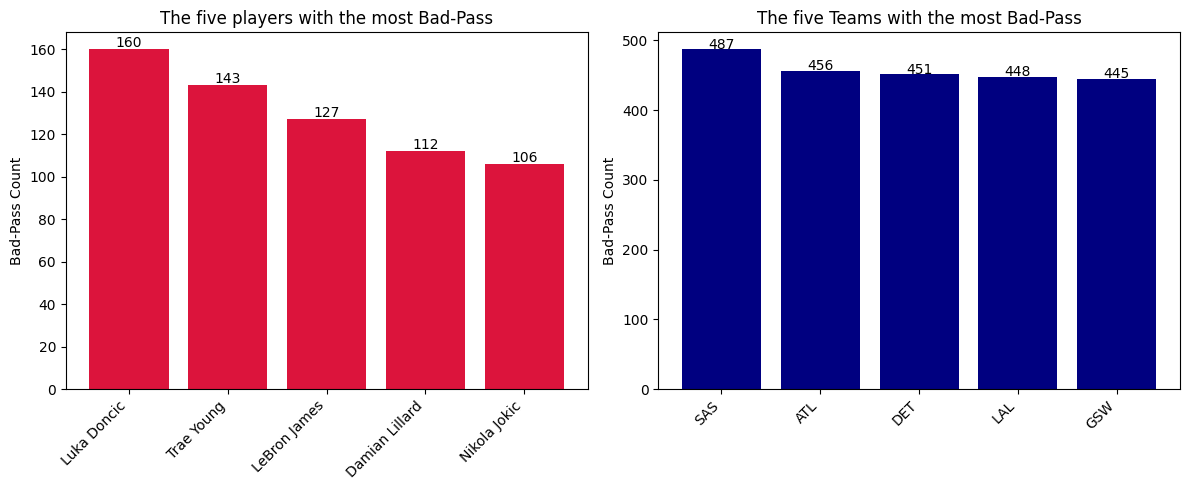

: 

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of Bad-Passes for each player and each team
df_to = df[df.EVENTMSGTYPE == 5]  
bad_by_player = df_to[df_to.target == 1].groupby("PLAYER1_NAME").size()
bad_by_team   = df_to[df_to.target == 1].groupby("PLAYER1_TEAM_ABBREVIATION").size()

# Select the top 5 items with the highest frequency
top5_players = bad_by_player.nlargest(5)
top5_teams   = bad_by_team.nlargest(5)

# Draw a diagram
plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
bars = plt.bar(top5_players.index, top5_players.values, color="crimson")
plt.title("The five players with the most Bad-Pass")
plt.ylabel("Bad-Pass Count")
plt.xticks(rotation=45, ha="right")
for bar in bars:
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1,
             int(bar.get_height()), ha="center")


plt.subplot(1,2,2)
bars = plt.bar(top5_teams.index, top5_teams.values, color="navy")
plt.title("The five Teams with the most Bad-Pass")
plt.ylabel("Bad-Pass Count")
plt.xticks(rotation=45, ha="right")
for bar in bars:
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1,
             int(bar.get_height()), ha="center")

plt.tight_layout()
plt.show()


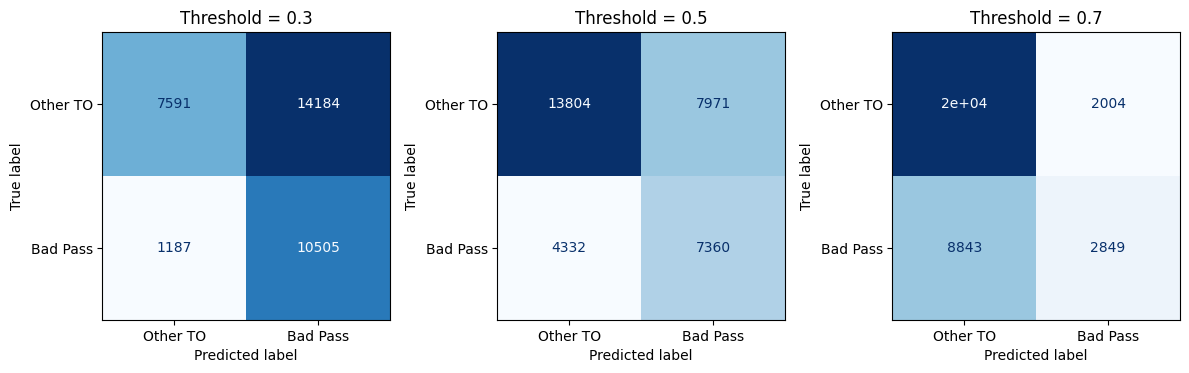

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Full-season Real Labels and OOF Prediction Probabilities
y_true  = y
y_score = oof_pred

# The three thresholds to be evaluated
thresholds = [0.3, 0.5, 0.7]

plt.figure(figsize=(12, 4))

for i, thresh in enumerate(thresholds, 1):
    
    y_pred = (y_score >= thresh).astype(int)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        cm, display_labels=["Other TO", "Bad Pass"]
    )

    
    ax = plt.subplot(1, 3, i)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    ax.set_title(f"Threshold = {thresh:.1f}")

plt.tight_layout()
plt.show()


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.base import clone



# Competition-level 80/20 division (strictly evaluated on the test set)
games = df["GAME_ID"].unique()
train_games, test_games = train_test_split(games, test_size=0.20, random_state=42)
mask_tr = df["GAME_ID"].isin(train_games).values
mask_te = df["GAME_ID"].isin(test_games).values

est = clone(models_stk["Stacked_RF"]).fit(X_stk[mask_tr], y[mask_tr])
scores = np.full(len(y), np.nan)
scores[mask_te] = est.predict_proba(X_stk[mask_te])[:, 1]   # Only give scores to the test set

# Select the top 5 objects (by default, based on the number of bad-passes)
def pick_top5(df, y, col, rank_by="BP"):
    agg = (df.assign(is_bp=np.array(y, dtype=int))
             .groupby(col)["is_bp"].agg(["sum","count"])
             .rename(columns={"sum":"BP","count":"TO"}))
    key = "BP" if rank_by=="BP" else "TO"
    return agg.sort_values(key, ascending=False).head(5).index.tolist()

players_top5 = pick_top5(df, y, "PLAYER1_NAME", rank_by="BP")
teams_top5   = pick_top5(df, y, "PLAYER1_TEAM_ABBREVIATION", rank_by="BP")

# Evaluation function: Calculate AUC/AP/Brier on the test set
def perf_table(df, y, scores, valid_mask, subject_col, subjects):
    rows = []
    for name in subjects:
        m = (df[subject_col].values == name) & valid_mask & ~np.isnan(scores)
        if m.sum() == 0:
            rows.append({subject_col: name, "AUC": np.nan, "AP": np.nan, "Brier": np.nan})
            continue
        yt, pb = y[m], scores[m]
        auc = roc_auc_score(yt, pb) if len(np.unique(yt)) > 1 else np.nan
        ap  = average_precision_score(yt, pb)
        br  = brier_score_loss(yt, pb)
        rows.append({subject_col: name, "AUC": auc, "AP": ap, "Brier": br})
    tb = pd.DataFrame(rows)
    
    return tb[[subject_col, "AUC", "AP", "Brier"]].round(3)


print("\n=== Top-5 Players (test-set performance) ===")
tbl_players = perf_table(df, y, scores, mask_te, "PLAYER1_NAME", players_top5)
print(tbl_players.to_string(index=False))

print("\n=== Top-5 Teams (test-set performance) ===")
tbl_teams = perf_table(df, y, scores, mask_te, "PLAYER1_TEAM_ABBREVIATION", teams_top5)
print(tbl_teams.to_string(index=False))



=== Top-5 Players (test-set performance) ===
  PLAYER1_NAME   AUC    AP  Brier
   Luka Doncic 0.843 0.892  0.164
    Trae Young 0.702 0.806  0.215
  LeBron James 0.681 0.718  0.219
Damian Lillard 0.632 0.706  0.232
  Nikola Jokic 0.778 0.779  0.191

=== Top-5 Teams (test-set performance) ===
PLAYER1_TEAM_ABBREVIATION   AUC    AP  Brier
                      SAS 0.718 0.611  0.213
                      ATL 0.669 0.621  0.235
                      DET 0.669 0.603  0.234
                      LAL 0.733 0.651  0.212
                      GSW 0.669 0.590  0.216


**Season generalisation.** Reuse **same configuration** to evaluate 2021→2023 / 2022→2023.
9. **Artifacts.** Save model (Stage-2), plots, and CSV outputs to `outputs/`.

In [28]:
import numpy as np, pandas as pd, warnings
from pathlib import Path
warnings.filterwarnings("ignore")
np.random.seed(42)

SEASONS = ["2021", "2022", "2023"]
FILES   = {y: Path(f"nbastats_{y}.csv") for y in SEASONS}

TURNOVER = 5
BADPASS  = 1

#  LightGBM The optimal parameters
lgbm_params = dict(
    n_estimators=600, learning_rate=0.05,
    num_leaves=63, min_child_samples=20,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, class_weight="balanced",
    random_state=42, n_jobs=-1
)


In [ ]:
def score2num(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().replace("'", "")
    return 0.0 if x.upper()=="TIE" else pd.to_numeric(x, errors="coerce")

def clock2sec(t):
    if pd.isna(t): return np.nan
    try:
        m, s = map(int, str(t).strip().split(":"))
        return m*60 + s
    except:
        return np.nan

def make_features(path: Path):
    df_raw = pd.read_csv(path)
    df = df_raw[df_raw.EVENTMSGTYPE == TURNOVER].copy()
    df["target"] = (df.EVENTMSGACTIONTYPE == BADPASS).astype(int)

    df["score_margin"]    = df.SCOREMARGIN.apply(score2num)
    df["sec_left_period"] = df.PCTIMESTRING.apply(clock2sec)
    df["sec_left_game"]   = df.sec_left_period + np.where(df.PERIOD<=4,(4-df.PERIOD)*720,0)

    for k in (1,2,3):
        df[f"prev_ev{k}"] = (df.groupby("GAME_ID")["EVENTMSGTYPE"]
                               .shift(k).fillna(0).astype(int))

    df["score_bin"] = pd.cut(df.score_margin, [-40,-15,-5,5,15,40],
                             labels=["<-15","-15~-5","-5~5","5~15",">15"])
    df["time_bin"]  = pd.cut(df.sec_left_period, [0,60,180,360,720],
                             labels=["0-1min","1-3","3-6","6-12"])

    df = df.sort_values(["GAME_ID","PERIOD","sec_left_period"],
                        ascending=[True,True,False])
    df["bp_last20events"] = (df.groupby("GAME_ID")["target"]
                          .rolling(20,1).sum()
                          .reset_index(level=0, drop=True))

    num_cols = ["PERIOD","sec_left_period","sec_left_game",
                "score_margin","bp_last20events",
                "prev_ev1","prev_ev2","prev_ev3"]
    cat_cols = ["PLAYER1_TEAM_ID","score_bin","time_bin"]

    X = df[num_cols + cat_cols].copy()
    y = df["target"].astype(int)
    groups = df["GAME_ID"]

    for c in cat_cols:
        X[c] = X[c].astype("category")

    return df, X, y, groups, num_cols, cat_cols

# Load three seasons
D, Xs, ys, Gs = {}, {}, {}, {}
for y in SEASONS:
    df, X, yy, gg, num_cols, cat_cols = make_features(FILES[y])
    D[y], Xs[y], ys[y], Gs[y] = df, X, yy, gg

print({y: (len(ys[y]), round(float(ys[y].mean()),3)) for y in SEASONS})


{'2021': (33857, 0.363), '2022': (34678, 0.336), '2023': (33467, 0.349)}


In [38]:
# Align the "category sets" of the classification columns of multiple DataFrames into a union to avoid prediction errors in cross-season scenarios
def align_categories(X_list, cat_cols):
    # Calculate the union category of each classification column
    unions = {}
    for c in cat_cols:
        cats = set()
        for X in X_list:
            if pd.api.types.is_categorical_dtype(X[c]):
                cats |= set(X[c].cat.categories)
            else:
                cats |= set(pd.Categorical(X[c]).categories)
        unions[c] = pd.CategoricalDtype(sorted(cats))
    # Application of Union Set
    X_aligned = []
    for X in X_list:
        Xc = X.copy()
        for c in cat_cols:
            Xc[c] = Xc[c].astype(unions[c])
        X_aligned.append(Xc)
    return X_aligned

# Usage example: Call within a specific train/test pair.


In [39]:
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMClassifier
import numpy as np

def gen_oof_lgb(X, y, groups, cat_cols, params, n_splits=5):
    """Training season internal OOF probability"""
    oof = np.zeros(len(y), dtype=float)
    gkf = GroupKFold(n_splits=n_splits)
    for tr, te in gkf.split(X, y, groups):
        clf = LGBMClassifier(**params)
        clf.fit(X.iloc[tr], y.iloc[tr], categorical_feature=cat_cols)
        oof[te] = clf.predict_proba(X.iloc[te])[:,1]
    return oof

def fit_stage1_and_predict_test(X_train, y_train, X_test, cat_cols, params):
    """Fit the first model using the entire training season, and then predict the probability on the test season."""
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train, categorical_feature=cat_cols)
    p_test = clf.predict_proba(X_test)[:,1]
    return p_test


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

def make_stacked_rf(num_cols, cat_cols):
    num_cols_stk = num_cols + ["oof_pred"]  # List the first-level probabilities as numerical values
    prep_tree_stk = ColumnTransformer([
        ("num", SimpleImputer(strategy="median"), num_cols_stk),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh",  OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ])
    model = Pipeline([
        ("prep", prep_tree_stk),
        ("clf", RandomForestClassifier(
            n_estimators=400, class_weight="balanced",
            n_jobs=-1, random_state=42))
    ])
    return model


In [41]:
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.base import clone

def eval_pair_stacked(train_season, test_season, n_splits_oof=5):
    # Extract the original X/y and align the classification columns
    X_tr_raw, X_te_raw = Xs[train_season], Xs[test_season]
    X_tr, X_te = align_categories([X_tr_raw, X_te_raw], cat_cols)
    y_tr, y_te = ys[train_season], ys[test_season]

    # Generate first-level OOF during the training season
    oof_tr = gen_oof_lgb(X_tr, y_tr, Gs[train_season], cat_cols, lgbm_params, n_splits=n_splits_oof)

    # 2) Fit the first level using the full training season, and then predict the probability of achieving the first level in the test season.
    p_te = fit_stage1_and_predict_test(X_tr, y_tr, X_te, cat_cols, lgbm_params)

    # 3) Construct secondary training/testing features
    X_tr_stk = X_tr.copy(); X_tr_stk["oof_pred"] = oof_tr
    X_te_stk = X_te.copy(); X_te_stk["oof_pred"] = p_te

    # 4) Train the secondary model and evaluate it in the testing season.
    stk = make_stacked_rf(num_cols, cat_cols)
    stk = stk.fit(X_tr_stk, y_tr)
    proba = stk.predict_proba(X_te_stk)[:,1]

    auc   = roc_auc_score(y_te, proba) if y_te.nunique()>1 else np.nan
    ap    = average_precision_score(y_te, proba)
    brier = brier_score_loss(y_te, proba)

    return {"train": train_season, "test": test_season,
            "AUC": round(float(auc),4) if auc==auc else np.nan,
            "AP": round(float(ap),4),
            "Brier": round(float(brier),4)}


In [42]:
# One-way
pairs = [("2021","2022"), ("2021","2023"), ("2022","2023")]
rows = []
for tr, te in pairs:
    rows.append(eval_pair_stacked(tr, te, n_splits_oof=5))

# Rolling: Combine 2021 and 2022 to form a "training season"
def concat_Xy(seasons):
    X_list = [Xs[s] for s in seasons]
    # Align the classification column (align with 2023)）
    X_tr, X_te = align_categories([pd.concat(X_list, ignore_index=True), Xs["2023"]], cat_cols)
    y_tr = pd.concat([ys[s] for s in seasons], ignore_index=True)
    y_te = ys["2023"]
    return X_tr, y_tr, X_te, y_te

# Generate the season-level OOF and test-season-level probability required for the scrolling process
def eval_rolling_stacked(train_seasons, test_season, n_splits_oof=5):
    X_tr_all, y_tr_all, X_te, y_te = None, None, None, None
    X_tr_all, y_tr_all, X_te, y_te = concat_Xy(train_seasons)


    g_tr = []
    offset = 0
    for s in train_seasons:
        g_tr.extend([f"{s}_{gid}" for gid in Gs[s]])
    g_tr = pd.Series(g_tr).reset_index(drop=True)

    # Realign the classification column again to ensure consistency
    X_tr_all, X_te = align_categories([X_tr_all, X_te], cat_cols)

    
    oof_tr = gen_oof_lgb(X_tr_all, y_tr_all, g_tr, cat_cols, lgbm_params, n_splits=n_splits_oof)
    p_te   = fit_stage1_and_predict_test(X_tr_all, y_tr_all, X_te, cat_cols, lgbm_params)

    X_tr_stk = X_tr_all.copy(); X_tr_stk["oof_pred"] = oof_tr
    X_te_stk = X_te.copy();     X_te_stk["oof_pred"] = p_te

    stk = make_stacked_rf(num_cols, cat_cols).fit(X_tr_stk, y_tr_all)
    proba = stk.predict_proba(X_te_stk)[:,1]

    auc   = roc_auc_score(y_te, proba) if y_te.nunique()>1 else np.nan
    ap    = average_precision_score(y_te, proba)
    brier = brier_score_loss(y_te, proba)

    return {"train": "+".join(train_seasons), "test": test_season,
            "AUC": round(float(auc),4) if auc==auc else np.nan,
            "AP": round(float(ap),4),
            "Brier": round(float(brier),4)}

rows.append(eval_rolling_stacked(["2021","2022"], "2023", n_splits_oof=5))

# 展示
tbl = pd.DataFrame(rows, columns=["train","test","AUC","AP","Brier"])
print("\n=== Cross-season performance (Stacked_RF) ===")
print(tbl.to_string(index=False))


[LightGBM] [Info] Number of positive: 9837, number of negative: 17248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 27085, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 9807, number of negative: 17278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 27085, number of used features: 9
[LightGBM] [Info] [binar

In [43]:


from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.model_selection import GroupKFold
from sklearn.base import clone
import numpy as np
import pandas as pd

def stacked_predict_to_2023(train_seasons, n_splits_oof=5):
    
    if isinstance(train_seasons, (list, tuple)):
        X_tr = pd.concat([Xs[s] for s in train_seasons], ignore_index=True)
        y_tr = pd.concat([ys[s] for s in train_seasons], ignore_index=True)
        g_tr = []
        for s in train_seasons:
            g_tr.extend([f"{s}_{gid}" for gid in Gs[s]])
        g_tr = pd.Series(g_tr).reset_index(drop=True)
        label = "+".join(train_seasons)
    else:
        X_tr, y_tr, g_tr = Xs[train_seasons], ys[train_seasons], Gs[train_seasons]
        label = train_seasons

    # Test set is fixed at 2023
    X_te = Xs["2023"].copy(); y_te = ys["2023"].copy(); g_te = Gs["2023"].reset_index(drop=True)

    # Align the classification column
    X_tr, X_te = align_categories([X_tr, X_te], cat_cols)

    
    oof_tr = gen_oof_lgb(X_tr, y_tr, g_tr, cat_cols, lgbm_params, n_splits=n_splits_oof)
    p_te   = fit_stage1_and_predict_test(X_tr, y_tr, X_te, cat_cols, lgbm_params)

    
    X_tr_stk = X_tr.copy(); X_tr_stk["oof_pred"] = oof_tr
    X_te_stk = X_te.copy(); X_te_stk["oof_pred"] = p_te
    stk = make_stacked_rf(num_cols, cat_cols).fit(X_tr_stk, y_tr)
    proba = stk.predict_proba(X_te_stk)[:,1]

    return dict(name=label, y=y_te.reset_index(drop=True), p=proba, groups=g_te)
    

pred_2021 = stacked_predict_to_2023("2021")
pred_2022 = stacked_predict_to_2023("2022")
pred_12   = stacked_predict_to_2023(["2021","2022"])
PRED_2023_LIST = [pred_2021, pred_2022, pred_12]


[LightGBM] [Info] Number of positive: 9837, number of negative: 17248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 27085, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 9807, number of negative: 17278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 27085, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM

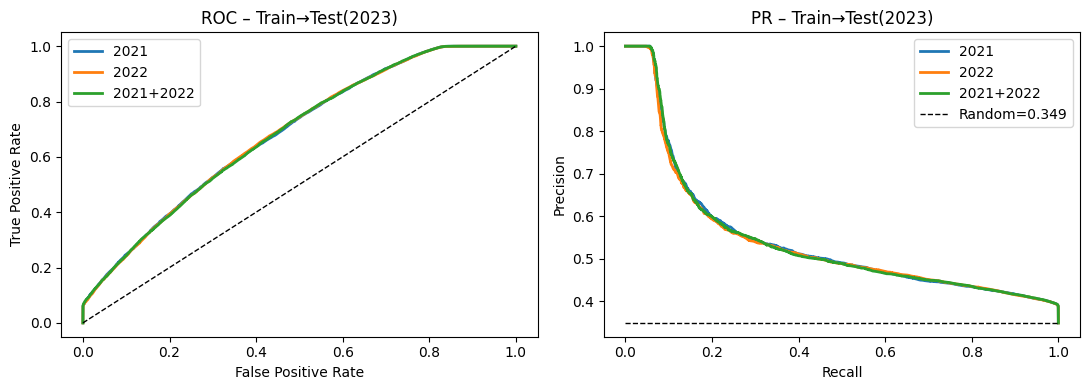

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

plt.figure(figsize=(11,4))

# ROC
plt.subplot(1,2,1)
for d in PRED_2023_LIST:
    fpr, tpr, _ = roc_curve(d["y"], d["p"])
    plt.plot(fpr, tpr, lw=2, label=d["name"])
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC – Train→Test(2023)")
plt.legend()

# PR
plt.subplot(1,2,2)
base = float(pred_2021["y"].mean())
for d in PRED_2023_LIST:
    prec, rec, _ = precision_recall_curve(d["y"], d["p"])
    plt.plot(rec, prec, lw=2, label=d["name"])
plt.hlines(base, 0, 1, linestyles="dashed", linewidth=1, colors="k", label=f"Random={base:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR – Train→Test(2023)")
plt.legend()
plt.tight_layout(); plt.show()


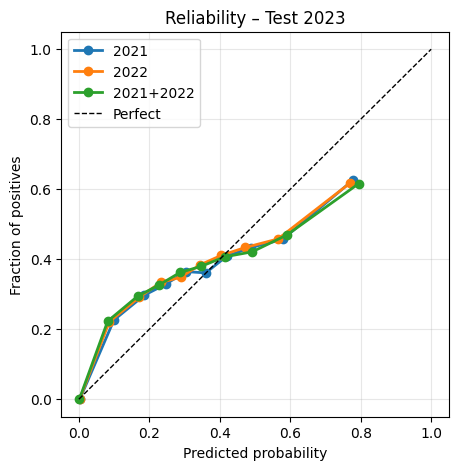

In [45]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
for d in PRED_2023_LIST:
    pt, pp = calibration_curve(d["y"], d["p"], n_bins=10, strategy="quantile")
    plt.plot(pp, pt, marker='o', lw=2, label=d["name"])
plt.plot([0,1],[0,1],'k--',lw=1, label="Perfect")
plt.xlabel("Predicted probability"); plt.ylabel("Fraction of positives")
plt.title("Reliability – Test 2023")
plt.legend(); plt.grid(alpha=.3); plt.show()


    Train   AUC  AUC_lo  AUC_hi    AP  AP_lo  AP_hi  Brier  Brier_lo  Brier_hi
     2021 0.683   0.679   0.687 0.542  0.535  0.548  0.208     0.206     0.210
     2022 0.683   0.679   0.688 0.539  0.532  0.546  0.209     0.207     0.211
2021+2022 0.683   0.679   0.687 0.541  0.535  0.548  0.211     0.209     0.212


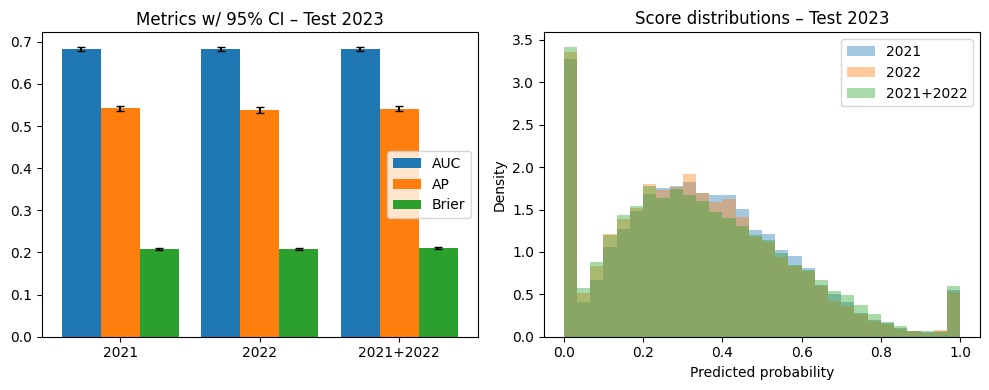

In [46]:
import numpy as np, pandas as pd
from numpy.random import default_rng
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

def metrics_ci_grouped(y, p, groups, B=1000, seed=42):
    rng = default_rng(seed)
    games = pd.Series(groups).unique()
    aucs, aps, brs = [], [], []
    for _ in range(B):
        sample_games = rng.choice(games, size=len(games), replace=True)
        idx = pd.Series(groups).isin(sample_games).values
        yb, pb = y[idx], p[idx]
        if len(np.unique(yb))>1:
            aucs.append(roc_auc_score(yb, pb))
        aps.append(average_precision_score(yb, pb))
        brs.append(brier_score_loss(yb, pb))
    def CI(a): 
        return np.nanmean(a), np.nanpercentile(a, 2.5), np.nanpercentile(a, 97.5)
    return {"AUC": CI(aucs), "AP": CI(aps), "Brier": CI(brs)}


rows=[]
for d in PRED_2023_LIST:
    stat = metrics_ci_grouped(d["y"].values, d["p"], d["groups"])
    rows.append([d["name"], *stat["AUC"], *stat["AP"], *stat["Brier"]])

tbl = pd.DataFrame(rows, columns=[
    "Train","AUC","AUC_lo","AUC_hi","AP","AP_lo","AP_hi","Brier","Brier_lo","Brier_hi"
]).round(3)
print(tbl.to_string(index=False))

# Visualization (error bars = 95% confidence interval)
import matplotlib.pyplot as plt
labels = tbl["Train"].tolist()
x = np.arange(len(labels)); w = 0.28

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(x- w, tbl["AUC"],  width=w, label="AUC",   yerr=[tbl["AUC"]-tbl["AUC_lo"],  tbl["AUC_hi"]-tbl["AUC"]], capsize=3)
plt.bar(x    , tbl["AP"],   width=w, label="AP",    yerr=[tbl["AP"]-tbl["AP_lo"],    tbl["AP_hi"]-tbl["AP"]],   capsize=3)
plt.bar(x+ w, tbl["Brier"], width=w, label="Brier", yerr=[tbl["Brier"]-tbl["Brier_lo"], tbl["Brier_hi"]-tbl["Brier"]], capsize=3)
plt.xticks(x, labels); plt.title("Metrics w/ 95% CI – Test 2023"); plt.legend()


plt.subplot(1,2,2)
for d in PRED_2023_LIST:
    plt.hist(d["p"], bins=30, density=True, alpha=.4, label=d["name"])
plt.xlabel("Predicted probability"); plt.ylabel("Density")
plt.title("Score distributions – Test 2023")
plt.legend(); plt.tight_layout(); plt.show()


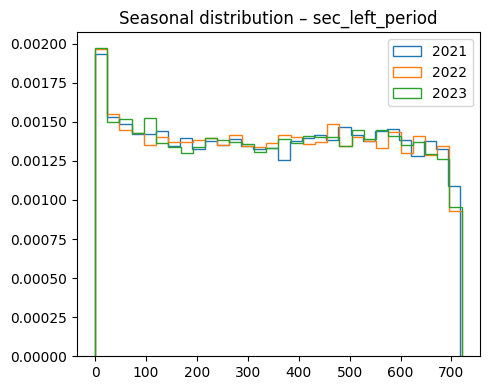

In [47]:
import matplotlib.pyplot as plt

def compare_hist(feature, bins=30):
    plt.figure(figsize=(5,4))
    for s in ["2021","2022","2023"]:
        plt.hist(D[s][feature], bins=bins, histtype="step", density=True, label=s)
    plt.title(f"Seasonal distribution – {feature}")
    plt.legend(); plt.tight_layout(); plt.show()

compare_hist("sec_left_period", bins=30)

